# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [55]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

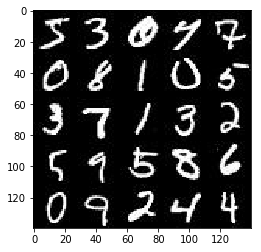

In [56]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

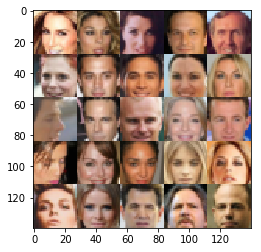

In [57]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\Pitto\Anaconda3\envs\tensorflow1_1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [59]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [60]:
def LeakyReLU(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [61]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        strt = 7
        st_filt = 512 
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding="SAME")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding="SAME")
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [62]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_out_real,d_logits_real = discriminator(input_real, False)
    g_model = generator(input_z, out_channel_dim)
    d_out_fake,d_logits_fake = discriminator(g_model, True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [63]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [64]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [65]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    b,x,y,c=data_shape
    input_real, input_z, _ = model_inputs(x, y, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 0
            for batch_images in get_batches(batch_size):
                ii = ii+1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                if ii % 10 == 0 : 
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if ii % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6531... Generator Loss: 0.0535
Epoch 1/2... Discriminator Loss: 2.4076... Generator Loss: 0.1802
Epoch 1/2... Discriminator Loss: 1.9081... Generator Loss: 0.4286
Epoch 1/2... Discriminator Loss: 1.9946... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 2.0570... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 0.8360... Generator Loss: 1.2243
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.4000


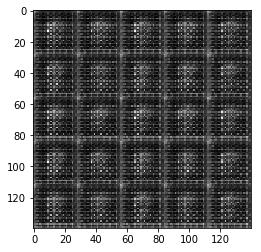

Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 1.5789... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.5071... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 1.0530
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 1.6625... Generator Loss: 0.7202


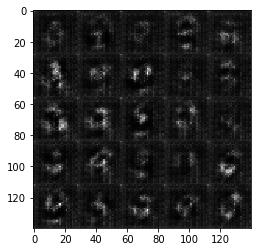

Epoch 1/2... Discriminator Loss: 1.5282... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 0.7797
Epoch 1/2... Discriminator Loss: 1.6366... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 1.1258
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.9361


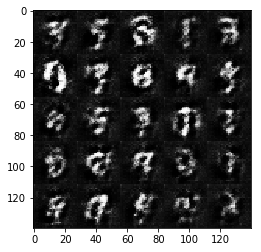

Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.9445
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.9019
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.6249


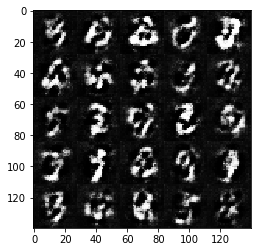

Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 1.0148
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.8535
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.0465
Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.6214... Generator Loss: 0.3882
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 0.8655


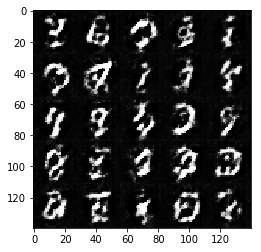

Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.1821
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 1.2404
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.9824
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 1.8242
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.7719


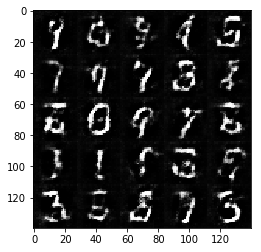

Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.0976
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 1.5166... Generator Loss: 0.4508
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.8641


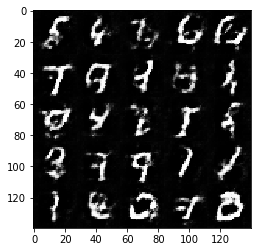

Epoch 1/2... Discriminator Loss: 1.5546... Generator Loss: 0.5129
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 1.5881
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.6975


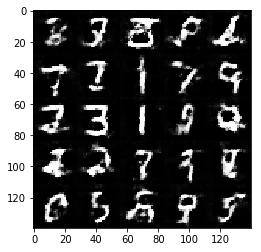

Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 1.1346
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.5295
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.9080


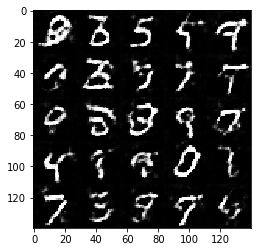

Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.8622
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.5264
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 1.0892
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.5623


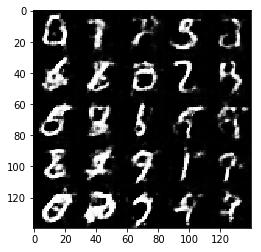

Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 1.2294
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.4883
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.6906
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 1.0771
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 1.1942
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.9752
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.5463


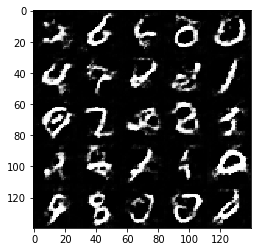

Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.7226
Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 1.1192


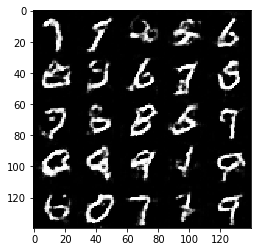

Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.8809
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.6269
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.9766
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.7250


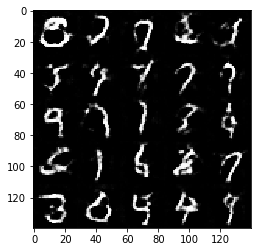

Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 1.1155
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 1.2210
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 1.1787
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.4434


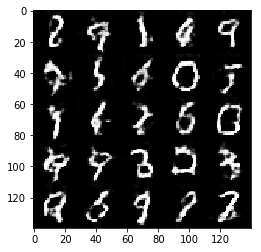

Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.9247
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 1.0795
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 0.7839


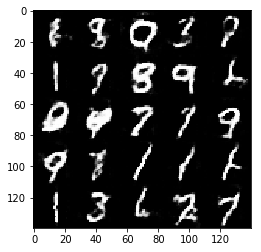

Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.6397
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 1.4863... Generator Loss: 0.5121


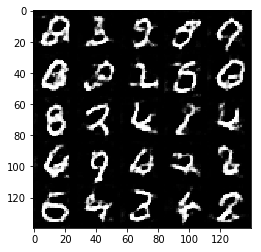

Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 0.9465
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.9469
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.0239
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 1.0532
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.6107... Generator Loss: 0.4410
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.0020


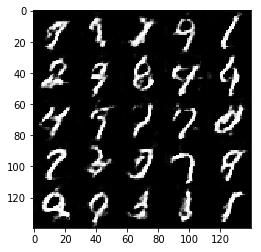

Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.0840
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.0985... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 0.8030
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 1.0991


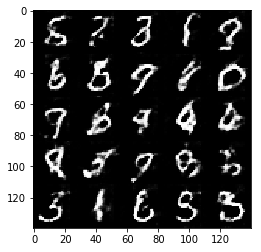

Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.6046
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.9136
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.4969... Generator Loss: 0.4651
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.5070
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 1.5278... Generator Loss: 0.4905
Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.8573
Epoch 2/2... Discriminator Loss: 1.5061... Generator Loss: 0.4470
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 0.7854
Epoch 2/2.

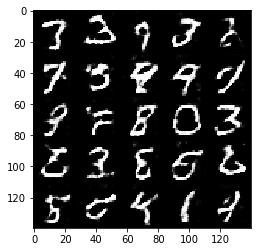

Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.7200


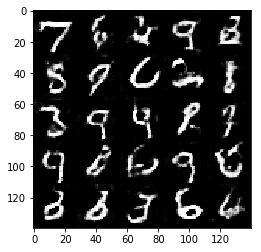

Epoch 2/2... Discriminator Loss: 1.4903... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 0.8780
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.5440


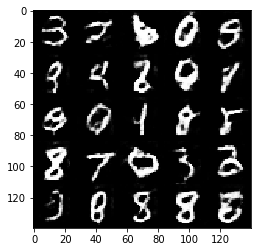

Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 1.1136
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.6120
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 1.0929
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.7655


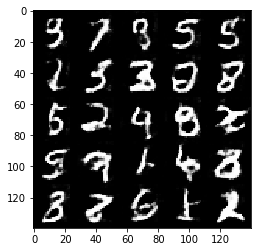

Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.6105
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 1.2479
Epoch 2/2... Discriminator Loss: 1.6153... Generator Loss: 0.4140
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.7652


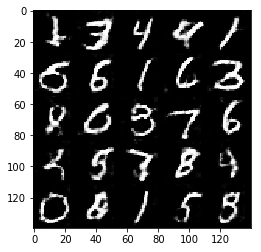

Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 1.3211
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.8713
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.4118
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 1.0036
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 1.3350
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 1.4852
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.7761


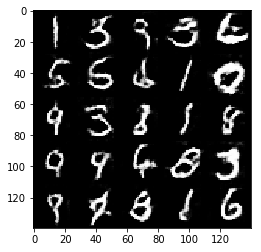

Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 1.0512
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 1.3971
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 1.6513
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 1.1848
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.9263
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.9234


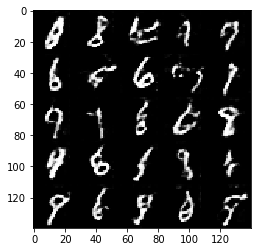

Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 1.1267
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.9177
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 1.0080
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.2953
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.4141


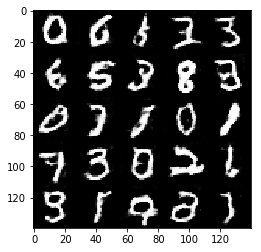

Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.7339
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 1.8099
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.5251... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 0.9224


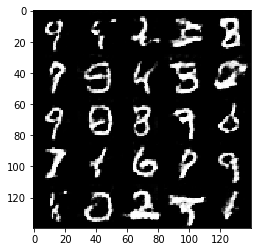

Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 1.1276
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.8729
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 0.9409
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 1.8794
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.9991


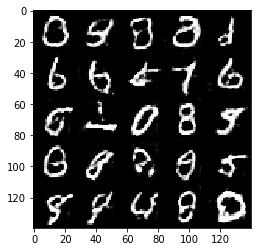

Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.6145
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.1273
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.1225
Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 1.0457
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.6378


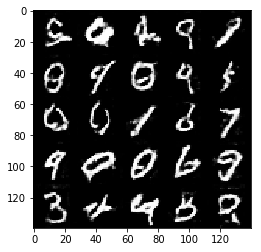

Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.9090
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 1.4965
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.0826
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.7168


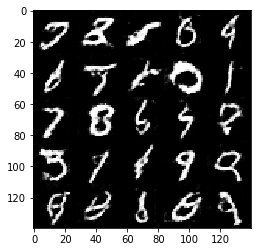

Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.5390
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 1.5291... Generator Loss: 0.4797
Epoch 2/2... Discriminator Loss: 0.7707... Generator Loss: 1.5392
Epoch 2/2... Discriminator Loss: 1.8451... Generator Loss: 0.3082
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.9465


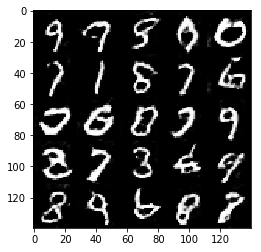

Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.4064
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.5713
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.5658
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 1.7148... Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 1.0400
Epoch 2/2... Discriminator Loss: 1.5291... Generator Loss: 0.4318


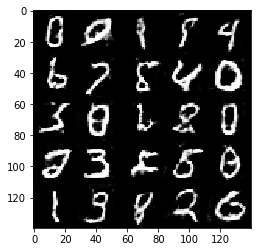

Epoch 2/2... Discriminator Loss: 0.9336... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.3297
Epoch 2/2... Discriminator Loss: 1.1924... Generator Loss: 0.6176
Epoch 2/2... Discriminator Loss: 1.5193... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.0267


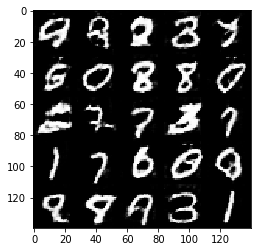

Epoch 2/2... Discriminator Loss: 1.5985... Generator Loss: 0.3999
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.5464
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 1.7133
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 1.1200
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 1.0583
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.5573


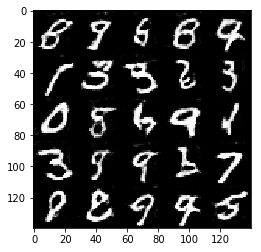

Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 0.8605
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 1.1324
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.4903
Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.7976


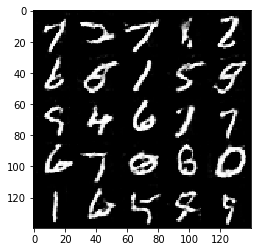

Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.7853
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.0320
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.5616
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.5332
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.7395
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 0.7231... Generator Loss: 1.4079


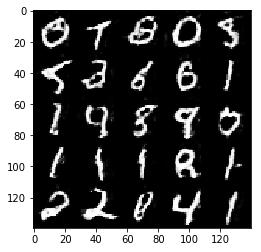

Epoch 2/2... Discriminator Loss: 1.1826... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 1.1324... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.2679


In [66]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8456... Generator Loss: 0.2575
Epoch 1/1... Discriminator Loss: 1.8049... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 2.1447
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 2.0351... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.7895... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 2.0205... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.7510... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 2.2636... Generator Loss: 0.4686


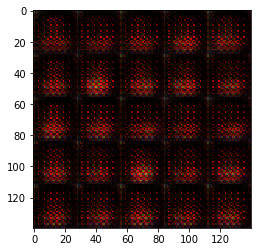

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.6498... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.9902


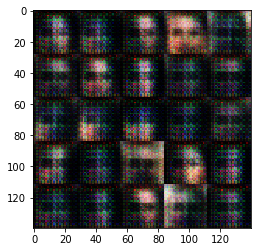

Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.7651... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.7798... Generator Loss: 0.4991


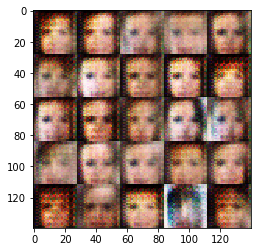

Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.6847... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 1.4510
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6053


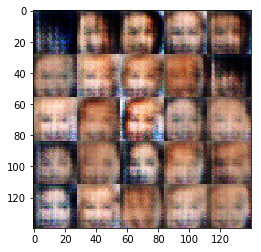

Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.5665


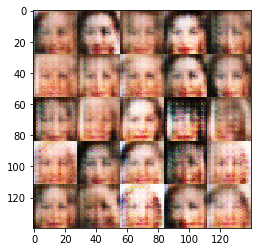

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8581


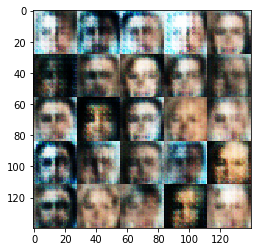

Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 1.0194


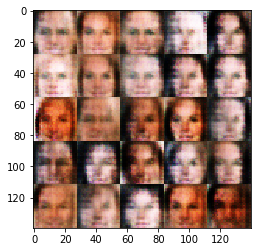

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.8928


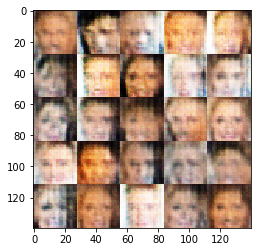

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 1.1858
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8255


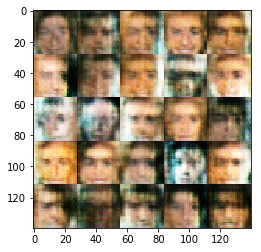

Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.9457


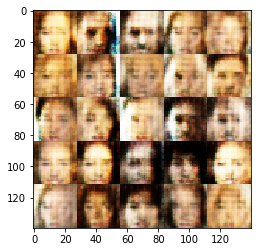

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8134


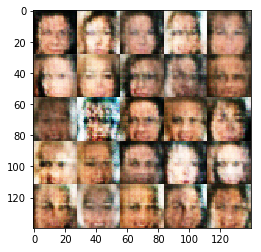

Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.9623


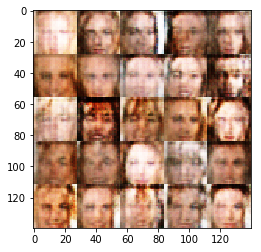

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.0466


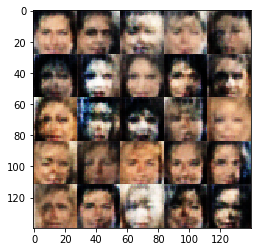

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 1.0102


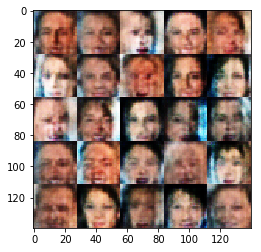

Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.7214


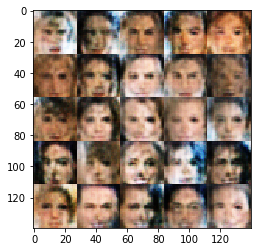

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9177


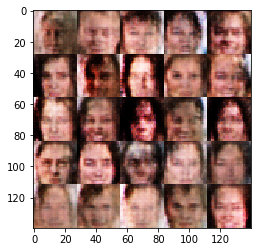

Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6953


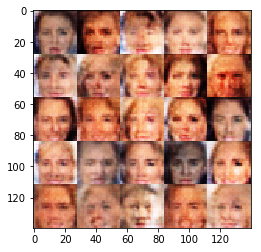

Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7257


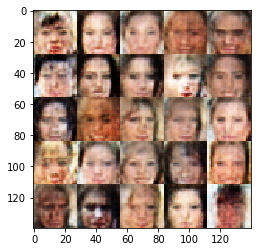

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.9910


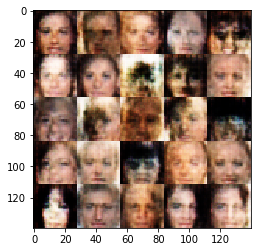

Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 1.1811


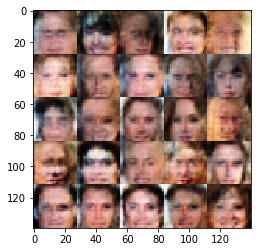

Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8288


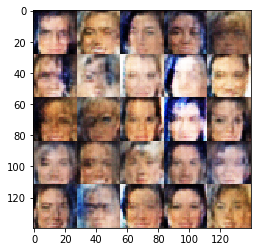

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8383


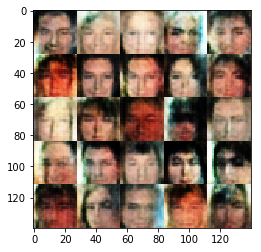

Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 1.1081


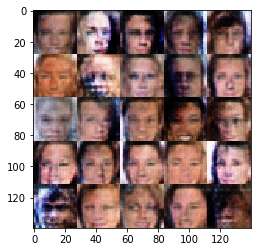

Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7439


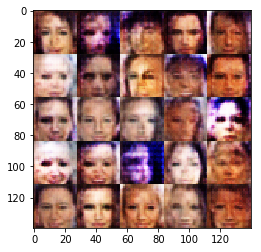

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.8981


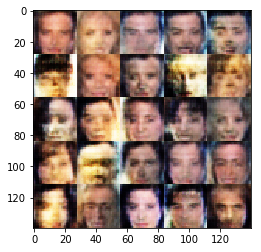

Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9867


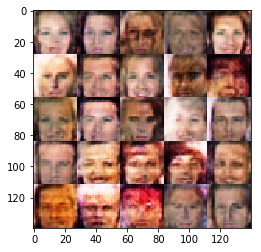

Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9471


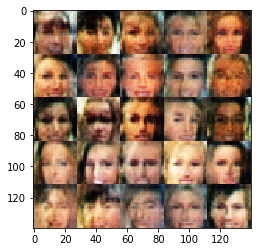

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8198


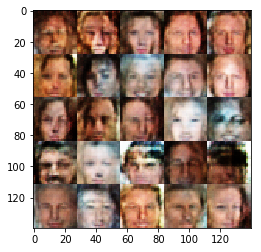

Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5862


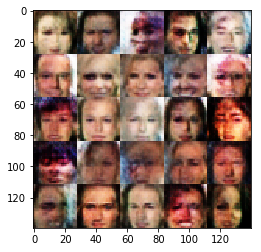

Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.5716


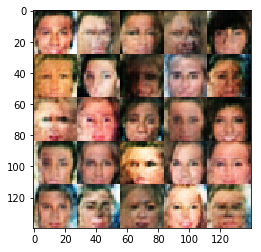

Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.9133


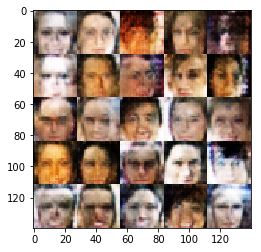

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.7147


In [67]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.